---



# <font color='#ECA702'>**Análisis Multimodal de Síntomas en la Enfermedad de Parkinson**</font>

In [1]:
#@title **Instalar paquetes necesarios**

%%capture
! pip install torchmetrics
! pip install wandb -Uq
! pip install onnx

In [2]:
#@title **Importar librerías**

# Manipulación de datos
import os
import cv2
import numpy as np
import librosa
import pandas as pd
from zipfile import ZipFile

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F

# Pytorch metrics
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryRecall, BinaryPrecision

# Pytorch essentials for datasets.
from torch.utils.data import Dataset, DataLoader

# sklearn
from sklearn.model_selection import GroupKFold

# wandb
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
#@title **Cargamos los datos desde Drive**

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/data_parkinson')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/data_parkinson


In [4]:
#@title **Extraer el zip**

os.mkdir('../../../../data')
os.popen('cp data.csv ../../../../data/data.csv')
target_path = os.path.join('../../../../data') # Aquí es donde van a quedar los datos
# deben quedar fuera de drive para poder acceder a ellos 'localmente'

# Unzip the downloaded files
zip_file_path = os.path.join('AudioVisualData_v7.zip')
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_path)

# # Me muevo hasta donde quedaron los datos
%cd ../../../../data
# Verifico
%ls

/data
AudioVisualData_v7/  data.csv


## <font color='#4C5FDA'>**Procesamiento del dataset**</font>

### <font color='#52F17F'>**Creación del Dataset Pandas auxiliar**</font>

In [5]:
data = pd.read_csv("data.csv", index_col='patient')

def string2array(string: str):
  """ Convierte un string con datos a numpy array """
  string = string.strip('[]')
  return np.fromstring(string, sep=',')

data['flatten_log_mel_spectogram'] = data['flatten_log_mel_spectogram'].apply(string2array)
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram
patient,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24...."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26...."


### <font color='#52F17F'>**Creación del Dataset PyTorch**</font>

In [6]:
"""
Constante sacada de la media de cantidad de frames de todos los vídeos multiplicada por 0.1
para tener el 10%
"""

FRAMES_PROMEDIO = 14

In [7]:
class PatientDataset(Dataset):
  def __init__(self, dataframe, n_frames = FRAMES_PROMEDIO):
    self.dataframe = dataframe
    # self.transform = transform
    self.n_frames = n_frames
    # self.audios = sorted(os.listdir(audio_dir)) # Listamos todas las imagenes en la carpeta

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):

    """ Carga de la imagen """

    # Entramos a la carpeta y conseguimos el audio de la lista
    # audio_path = os.path.join(self.audio_dir, self.audios[index])
    # audio_path = os.path.join(self.dataframe['audio_path'][index])

    # Leemos el audio
    audio = self.dataframe['flatten_log_mel_spectogram'][index].astype(np.float32)
    audio = audio.reshape((90, 10))
    audio = torch.from_numpy(audio).unsqueeze(0)

    """ Carga de los frames """

    # Entramos a la carpeta y conseguimos los frames de la lista.
      # La razon por la que uso la misma lista de audios es porque el audio y el vídeo
      # tienen el mismo nombre, solo cambia la ruta de la carpeta y la extensión.
    """ audios: AudioVisualData_v7/Control/C0/Phonemes/audio/C0-1-Pakata.mp3 """
    """ vídeo: AudioVisualData_v7/Control/C0/Phonemes/frames/C0-1-Pakata.mov """
    video_path = os.path.join(self.dataframe['frames_path'][index])
    # video_path = os.path.join(self.video_dir, self.audios[index].replace(".mp3", ".mov"))

    frames_path = sorted(os.listdir(video_path))[:self.n_frames]
    frames = []
    for frame in frames_path:
      frame_path = os.path.join(self.dataframe['frames_path'][index], frame)
      # print(frame_path)
      frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
      frame = cv2.resize(frame, (112, 112)) # Resize a 112x112
      frame = frame / 255. # Normalizamos entre 0 y 1
      frames.append(frame)

    frames = np.expand_dims(np.stack(frames), axis=1).astype('float32')
    frames = frames.transpose(1, 0, 2, 3)
    frames = torch.from_numpy(frames)

    """ Consiguiendo el label """

    # Para conseguir la etiqueta simplemente me tengo que fijar en la ruta. Si es 'Parkinson' 1
    # sino 0.

    label = 1 if 'Parkinson' in self.dataframe['audio_path'][index] else 0

    return audio, frames, label

In [8]:
complete_dataset = PatientDataset(data)
print(complete_dataset.__len__())
print(complete_dataset[0][0].shape, complete_dataset[0][1].shape , complete_dataset[0][2])

1091
torch.Size([1, 90, 10]) torch.Size([1, 14, 112, 112]) 0


### <font color='#52F17F'>**Visualización de los datos**</font>

In [ ]:
def plot_frame_strip(frames, rows=2, cols=7):
    """
    Hace un plot de la tira de frames en una matriz de imágenes.

    Args:
        frames (np.ndarray): Tensor de frames con forma (num_frames, height, width, channels).
        rows (int): Número de filas en la tira de frames.
        cols (int): Número de columnas en la tira de frames.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(20, 6))

    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < len(frames):
                axes[i, j].imshow(frames[idx], cmap='gray')
                axes[i, j].axis('off')
                axes[i, j].set_title(f"Frame: {idx}")
    plt.show()

In [ ]:
plot_frame_strip(complete_dataset[0][1].squeeze(0).numpy())

In [ ]:
complete_dataset[0][0].squeeze(0).numpy().reshape((90, 10)).shape

(90, 10)

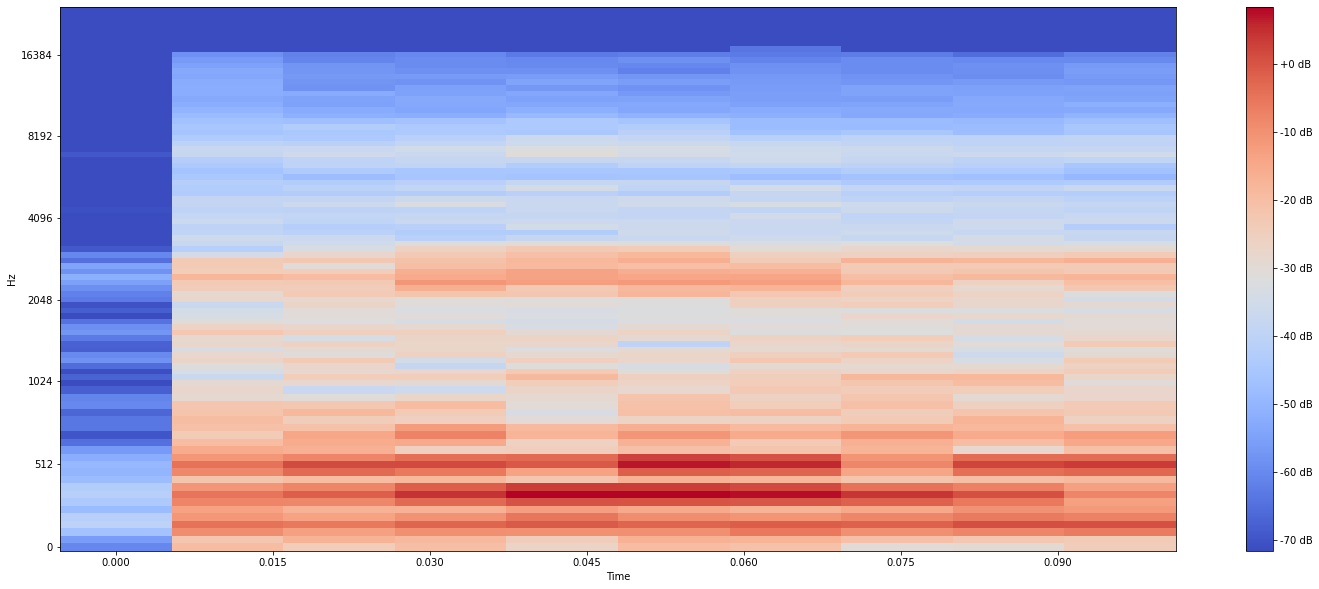

In [ ]:
plt.figure(figsize=(25,10))
librosa.display.specshow(complete_dataset[0][0].squeeze(0).numpy(), y_axis='mel', x_axis='time', sr=48000)
plt.colorbar(format="%+2.f dB")
plt.show()

### <font color='#52F17F'>**Partición de los datos**</font>

In [ ]:
# Extraer los datos para GroupKFold https://discuss.pytorch.org/t/custom-datatype-for-many-images-to-one-label/87629
X = [i for i in range(len(data))]
y = data['label'].values
groups = data.index.values

In [ ]:
groupk_folds = 7
gkf = GroupKFold(n_splits=groupk_folds)
# Realizar la validación cruzada por grupos
for i, (train_index, test_index) in enumerate(gkf.split(X, y, groups), 1):
    train_groups = groups[train_index]
    test_groups = groups[test_index]

    print(f"División {i}:")
    print("  Pacientes en entrenamiento:", np.unique(train_groups))
    print("  Pacientes en prueba:", np.unique(test_groups))
    print("  Número de pacientes en entrenamiento:", len(np.unique(train_groups)))
    print("  Número de pacientes en prueba:", len(np.unique(test_groups)))
    print()

División 1:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C4' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P7']
  Pacientes en prueba: ['C5' 'P8']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 2:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P8']
  Pacientes en prueba: ['C4' 'P7']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 3:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P7' 'P8']
  Pacientes en prueba: ['C3' 'P6']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 4:
  Pacientes en entrenamiento: ['C0' 'C1' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P6' 'P7' 'P8']
  Pacientes en prueba: ['C2' 'P5']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 5:
  Pacientes en entrenamiento: ['C0' 'C2' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P5' 'P6' 'P7' 'P8']
  Pacientes en prueba: [

### <font color='#52F17F'>**Make's for wandb**</font>

In [9]:
def get_data(train_index, test_index, data):
    full_dataset = PatientDataset(data)

    train_subset = torch.utils.data.Subset(full_dataset, train_index)
    test_subset = torch.utils.data.Subset(full_dataset, test_index)

    return train_subset, test_subset


def make_loader(dataset, batch_size):
    loader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         pin_memory=True, num_workers=2)
    return loader

def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = torch.optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer

## <font color='#ECA702'>**Modelo CNN 3D**</font>

### <font color='#52F17F'>**Creando el modelo**</font>

In [10]:
# Conventional and convolutional neural network

class ConvNet(nn.Module):
    def __init__(self, kernels, input_size=[1, 14, 112, 112], classes=1):
        super(ConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv3d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv3d(kernels[0], kernels[1], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))

        self.input_size = input_size
        self.kernels = kernels

        self.final_feature_size = self.calculate_final_feature_size()
        # Adjust the fully connected layer to use the final feature size
        self.fc = nn.Linear(self.final_feature_size, classes)
        # self.fc = nn.Linear(3 * 28 * 28 * kernels[-1], classes)

    def calculate_final_feature_size(self):
        size_d, size_h, size_w = self.input_size[1:]
        size_d = self.conv_output_size(size_d, 5, 1, 2) // 2  # layer1 depth
        size_h = self.conv_output_size(size_h, 5, 1, 2) // 2  # layer1 height
        size_w = self.conv_output_size(size_w, 5, 1, 2) // 2  # layer1 width

        size_d = self.conv_output_size(size_d, 5, 1, 2) // 2  # layer2 depth
        size_h = self.conv_output_size(size_h, 5, 1, 2) // 2  # layer2 height
        size_w = self.conv_output_size(size_w, 5, 1, 2) // 2  # layer2 width

        return size_d * size_h * size_w * self.kernels[-1]

    def conv_output_size(self, size, kernel_size, stride, padding):
        return (size - kernel_size + 2 * padding) // stride + 1

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [11]:
# Test al modelo, para ver si nos entrega la salida esperada

# n_channels = 1
# n_classes = 2
# input_audio = complete_dataset[0][0].unsqueeze(0)
input_video = complete_dataset[0][1].unsqueeze(0)
# print(f"Entrada audio: {input_audio.size(), input_audio.dtype}")
print(f"Entrada video: {input_video.size(), input_video.dtype}")

model = ConvNet(kernels=[32, 64], classes=1)
ouput = model(input_video)
print(f"Salida: {ouput.size()}")

Entrada video: (torch.Size([1, 1, 14, 112, 112]), torch.float32)
Salida: torch.Size([1, 1])


In [12]:
# Test al modelo, para ver si nos entrega la salida esperada

input_video = torch.rand([2, 1, 14, 112, 112])
# input_audio = torch.rand([2, 1, 90, 10])

# print(f"Entrada audio: {input_audio.size(), input_audio.dtype}")
print(f"Entrada video: {input_video.size(), input_video.dtype}")

model = ConvNet(kernels=[32, 64], classes=1)
ouput = model(input_video)
print(f"Salida: {ouput.size()}")

Entrada video: (torch.Size([2, 1, 14, 112, 112]), torch.float32)
Salida: torch.Size([2, 1])


In [13]:
f1_fn = BinaryF1Score()
acc_fn = BinaryAccuracy()
recall_fn = BinaryRecall()
precision_fn = BinaryPrecision()

In [14]:
target = torch.tensor([0, 1, 0, 1, 0, 1]).unsqueeze(1).float()
print(target.size(), target.dtype)
preds = torch.tensor([0.54, 0.76, 0.91, 0.87, 0.57, 0.99]).unsqueeze(1)
print(preds.size(), preds.dtype)
f1 = f1_fn(preds, target)
acc = acc_fn(preds, target)
recall = recall_fn(preds, target)
precision = precision_fn(preds, target)
print(f1, acc, recall, precision)

torch.Size([6, 1]) torch.float32
torch.Size([6, 1]) torch.float32
tensor(0.6667) tensor(0.5000) tensor(1.) tensor(0.5000)


### <font color='#52F17F'>**Entrenamiento del modelo**</font>

In [15]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def make(config, train_index, test_index, data):
    # Make the data
    train, test = get_data(train_index, test_index, data)
    train_loader = make_loader(train, batch_size=config.batch_size)
    test_loader = make_loader(test, batch_size=config.batch_size)

    # Make the model
    model = ConvNet(kernels=config.features, classes=config.classes).to(DEVICE)

    # Make the loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = build_optimizer(model, config.optimizer, config.learning_rate)

    # N-epochs to train
    epochs = config.epochs

    # Make metrics
    accuracy_fn = BinaryAccuracy().to(DEVICE)
    f1_score_fn = BinaryF1Score().to(DEVICE)
    recall_fn = BinaryRecall().to(DEVICE)
    precision_fn = BinaryPrecision().to(DEVICE)

    return model, train_loader, test_loader, criterion, optimizer, accuracy_fn, f1_score_fn, recall_fn, precision_fn, epochs

#### <font color='##6600CC'>**Training loop**</font>

In [16]:
def train_log(loss, accuracy, step, current):
    """ Log the metrics for the current batch into wandb

    Args:
        loss: the value of the loss at current batch
        accuracy: the value of the accuracy at current batch
        step: actual step
        current: actual batch
    """

    # Where the magic happens
    # wandb.log({"step":step, "loss": loss, "accuracy": accuracy}, step=step)
    wandb.log({"step":step, "train_loss": loss, "train_accuracy": accuracy})
    print(f"train loss: {loss:.3f} accuracy: {accuracy:.3f} [after {current} batches]")

In [17]:
def train_batch(images, labels, model, optimizer, criterion, metrics_fn):
    """Train the model on a single bacth of the dataloader.

    Args:
        dataloader: an instance of `torch.utils.data.DataLoader`, containing the training data.
        model: an instance of `torch.nn.Module`, the model to be trained.
        optimizer: an instance of `torch.optim.Optimizer`, the optimizer used for training.
        criterion: a callable, the loss function.
        metrics_fn: a callable, the metrics function.

    Returns:
        loss: the value of the loss at current batch
        accuracy: the value of the accuracy at current batch
    """

    images, labels = images.to(DEVICE), labels.to(DEVICE)

    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels.unsqueeze(1).float())
    accuracy = metrics_fn(outputs, labels.unsqueeze(1).float())

    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss, accuracy

In [18]:
def train(model, loader, criterion, optimizer, metric_fn, step):

    model.train()
    n_prints = int(len(loader)/4)

    # Run training and track with wandb
    for batch, (_, images, labels) in enumerate(loader):

        loss, accuracy = train_batch(images, labels, model, optimizer, criterion, metric_fn)

        # Report metrics every n_prints batch
        if batch % n_prints == n_prints-1:
            loss, current = loss.item(), batch
            # print(step)
            train_log(loss, accuracy, step, current)
            # Increment the step after logging
            step += 1
    return step

#### <font color='##6600CC'>**Evaluation loop**</font>

In [19]:
def test(model, test_loader, loss_fn, accuracy_fn, f1_score_fn, recall_fn, precision_fn, epoch):
    model.eval()

    # Run the model on some test examples
    num_batches = len(test_loader)
    val_loss, val_accuracy, val_f1, val_recall, val_precision = 0, 0, 0, 0, 0
    with torch.no_grad():
        for _, images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            val_loss += loss_fn(outputs, labels.unsqueeze(1).float()).item()
            val_accuracy += accuracy_fn(outputs, labels.unsqueeze(1).float())
            val_f1 += f1_score_fn(outputs, labels.unsqueeze(1).float())
            val_recall += recall_fn(outputs, labels.unsqueeze(1).float())
            val_precision += precision_fn(outputs, labels.unsqueeze(1).float())

    val_loss /= num_batches
    val_accuracy /= num_batches
    val_f1 /= num_batches
    val_recall /= num_batches
    val_precision /= num_batches

    # Log the evaluation metrics at the end of batches
    wandb.log({"epoch": epoch+1, "val_loss": val_loss, "val_accuracy": val_accuracy, "val_f1": val_f1, "val_recall": val_recall, "val_precision": val_precision})
    print(f"val loss: {val_loss:.3f} accuracy: {val_accuracy:.3f} [after {num_batches} batches]")
    return images, val_accuracy, val_f1, val_recall, val_precision

### <font color='#52F17F'>**Train and watch your metrics on wandb.ai**</font>

In [20]:
if os.path.exists('../models') == False:
  os.mkdir("../models")
MODELS_DIR = "../models"


def model_pipeline(num, sweep_id, sweep_run_name, hyperparameters, train_index, test_index, data):

    # tell wandb to get started
    run_name = f'{sweep_run_name}--{num}'
    with wandb.init(config=hyperparameters, dir=MODELS_DIR
                    , group=sweep_id, job_type=sweep_run_name, name=run_name, reinit=True):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_loader, test_loader, criterion, optimizer, accuracy_fn, f1_score_fn, recall_fn, precision_fn, epochs = make(config,
                                                                                                                                train_index,
                                                                                                                                test_index,
                                                                                                                                data)
      print(model)

      # Tell wandb to watch what the model gets up to: gradients, weights, and more!
      wandb.watch(model, criterion, log="all", log_freq=10)
      # and use them to train the model

      # Initialize the step counter
      step = 0
      best_val_accuracy = float('inf')
      patience = 10

      print(f'FOLD {num+1}')
      print('--------------------------------')

      # Estas métricas son el promedio luego de todas las épocas que alcance a tomar el modelo
      avg_val_accuracy_epochs, avg_val_recall_epochs, avg_val_precision_epochs, avg_val_f1_score_epochs = 0, 0, 0, 0

      for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        step = train(model, train_loader, criterion, optimizer, accuracy_fn, step=step)
        # and test its performance per epoch
        images, val_accuracy, val_f1, val_recall, val_precision = test(model, test_loader, criterion, accuracy_fn, f1_score_fn, recall_fn, precision_fn, epoch=t)

        avg_val_accuracy_epochs += val_accuracy
        avg_val_recall_epochs += val_recall
        avg_val_precision_epochs += val_precision
        avg_val_f1_score_epochs += val_f1

        # Early stopping
        if val_accuracy < best_val_accuracy:
          best_val_accuracy = val_accuracy
          patience = 10  # Reset patience counter
        else:
          patience -= 1
          if patience == 0:
              break

      avg_val_accuracy_epochs /= (t+1)
      avg_val_f1_score_epochs /= (t+1)
      avg_val_recall_epochs /= (t+1)
      avg_val_precision_epochs /= (t+1)

      # Save the model in the exchangeable ONNX format
      torch.onnx.export(model, images,"model.onnx")
      wandb.save("model.onnx")
      wandb.finish()

    return avg_val_accuracy_epochs, avg_val_f1_score_epochs, avg_val_recall_epochs, avg_val_precision_epochs

In [21]:
def reset_wandb_env():
    exclude = {
        "WANDB_PROJECT",
        "WANDB_ENTITY",
        "WANDB_API_KEY",
    }
    for key in os.environ.keys():
        if key.startswith("WANDB_") and key not in exclude:
            del os.environ[key]

In [22]:
def cross_validate():
    num_folds = 7
    gkf = GroupKFold(n_splits=num_folds)

    # Extraer los datos para GroupKFold https://discuss.pytorch.org/t/custom-datatype-for-many-images-to-one-label/87629
    X = [i for i in range(len(data))]
    y = data['label'].values
    groups = data.index.values


    sweep_run = wandb.init(dir=MODELS_DIR)
    sweep_id = sweep_run.sweep_id or "unknown"
    sweep_url = sweep_run.get_sweep_url()
    project_url = sweep_run.get_project_url()
    sweep_group_url = f'{project_url}/groups/{sweep_id}'
    sweep_run.notes = sweep_group_url
    sweep_run.save()
    sweep_run_name = sweep_run.name or sweep_run.id or "unknown_2"
    sweep_run_id = sweep_run.id
    sweep_run.finish()
    wandb.sdk.wandb_setup._setup(_reset=True)

    metrics = {
        "val_accuracy": [],
        "val_recall": [],
        "val_precision": [],
        "val_f1_score": []
    }
    for fold, (train_ids, test_ids) in enumerate(gkf.split(X, y, groups)):


        reset_wandb_env()

        # Entreno y valido cada run pasandole el sweep y la config
        val_accuracy, val_f1, val_recall, val_precision = model_pipeline(
            sweep_id=sweep_id, num=fold,
            sweep_run_name=sweep_run_name,
            hyperparameters=dict(sweep_run.config),
            train_index=train_ids,
            test_index=test_ids,
            data=data
        )
        metrics["val_accuracy"].append(val_accuracy)
        metrics["val_recall"].append(val_f1)
        metrics["val_precision"].append(val_recall)
        metrics["val_f1_score"].append(val_precision)

    # resume the sweep run
    sweep_run = wandb.init(id=sweep_run_id, resume="must", dir=MODELS_DIR)

    # Calcula los promedios de cada métrica
    avg_val_accuracy = sum(metrics["val_accuracy"]) / len(metrics["val_accuracy"])
    avg_val_recall = sum(metrics["val_recall"]) / len(metrics["val_recall"])
    avg_val_precision = sum(metrics["val_precision"]) / len(metrics["val_precision"])
    avg_val_f1_score = sum(metrics["val_f1_score"]) / len(metrics["val_f1_score"])
    # Log metrics to sweep run
    sweep_run.log({
        "val_accuracy": avg_val_accuracy,
        "val_recall": avg_val_recall,
        "val_precision": avg_val_precision,
        "val_f1": avg_val_f1_score
    })
    sweep_run.finish()

    print("*" * 40)
    print("Sweep URL:       ", sweep_url)
    print("Sweep Group URL: ", sweep_group_url)
    print("*" * 40)

In [23]:
sweep_configuration = {
    'method': 'random',
    'name': 'sweep-test-1',
    'metric': {
        'goal': 'maximize',
        'name': 'val_accuracy'
    },
    'parameters': {
        'epochs': {'value': 50},
        'classes': {'value': 1},
        'features': {'values': [[16, 32], [32, 64], [48, 64], [64, 128]]},
        'batch_size': {'values': [32, 64, 128]},
        'learning_rate': {'values': [0.01, 0.001, 0.0001]},
        'optimizer': {'values': ['adam', 'sgd']},
        'dataset': {'value': 'ParkinsonVideo'},
        'architecture': {'value': 'CNN'}
    },
    # 'early_terminate': {
    #     'type': 'hyperband',
    #     'eta': 2,
    #     'min_iter':2
    #  }
}

In [24]:
sweep_id = wandb.sweep(sweep_configuration, project='ai-1-project')
wandb.agent(sweep_id, function=cross_validate, count=10)

wandb.finish()

Create sweep with ID: okv6gisv
Sweep URL: https://wandb.ai/aiuis/ai-1-project/sweeps/okv6gisv


wandb: Agent Starting Run: fwqf960s with config:
wandb: 	architecture: CNN
wandb: 	batch_size: 64
wandb: 	classes: 1
wandb: 	dataset: ParkinsonVideo
wandb: 	epochs: 50
wandb: 	features: [16, 32]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: Currently logged in as: gpintoruiz (aiuis). Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=75264, out_features=1, bias=True)
)
FOLD 1
--------------------------------
Epoch 1
-------------------------------
train loss: 0.761 accuracy: 0.594 [after 2 batches]
train loss: 0.688 accuracy: 0.609 [after 5 batches]
train loss: 0.669 accuracy: 0.906 [after 8 batches]
train loss: 0.616 accuracy: 0.953 [after 11 batches]
train loss: 0.506 accuracy: 0.949 [after 14 batches]
val loss: 0.642 accuracy: 0.615 [after 3 batches]
Epoch 2
-------------------------------
train loss: 0.346 accuracy: 0.938 [after 2 batches]
train loss: 0.216 acc

epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▁▆▇▇██████▇█████████████████████████████
train_loss,█▇▆▃▂▁▁▅▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▁█▁▇▁█▇▁█▁▅▁▅▁▃
val_f1,▃▂█▂▆▁█▇▂█▂▅▂▅▁▃
val_loss,▂▃▁▄▂▃▁▁▅▁█▂▅▂▅▂
val_precision,▂▁▇▁█▁█▆▁█▁▃▁▄▁▂
val_recall,▇▇▇█▁▇▄▇█▄█▇█▇██
epoch,16
step,79


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=75264, out_features=1, bias=True)
)
FOLD 2
--------------------------------
Epoch 1
-------------------------------
train loss: 4.626 accuracy: 0.516 [after 2 batches]
train loss: 0.661 accuracy: 0.500 [after 5 batches]
train loss: 0.670 accuracy: 0.484 [after 8 batches]
train loss: 0.639 accuracy: 0.781 [after 11 batches]
train loss: 0.604 accuracy: 0.718 [after 14 batches]
val loss: 0.693 accuracy: 0.565 [after 3 batches]
Epoch 2
-------------------------------
train loss: 0.544 accuracy: 0.859 [after 2 batches]
train loss: 0.413 acc

epoch,▁▂▂▃▄▄▅▅▆▇▇█
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▁▁▅▄▇▆▇█████████████████████████████████
train_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▁▅▂▃▁▇███▆▇
val_f1,▇▁▆▂▄▁████▇▇
val_loss,▂▂▂▅▄█▂▁▁▁▂▂
val_precision,▁█▄█▇█▄█████
val_recall,█▁▆▂▂▁█▆▆▆▅▆
epoch,12
step,59


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=75264, out_features=1, bias=True)
)
FOLD 3
--------------------------------
Epoch 1
-------------------------------
train loss: 1.316 accuracy: 0.516 [after 2 batches]
train loss: 0.685 accuracy: 0.562 [after 5 batches]
train loss: 0.692 accuracy: 0.562 [after 8 batches]
train loss: 0.690 accuracy: 0.750 [after 11 batches]
train loss: 0.672 accuracy: 0.821 [after 14 batches]
val loss: 0.696 accuracy: 0.423 [after 3 batches]
Epoch 2
-------------------------------
train loss: 0.655 accuracy: 0.766 [after 2 batches]
train loss: 0.588 acc

epoch,▁▂▂▃▄▅▅▆▇▇█
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▁▂▂▅▅▅▇▅████████████████████████████████
train_loss,█▅▅▅▄▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▇▄█▆▆▆█▆▇
val_f1,█▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▆▆█▆█▆█▇
val_precision,█▁▄▁▁▁▁▁▆▁▆
val_recall,█▁▁▁▁▁▁▁▁▁▁
epoch,11
step,54


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=75264, out_features=1, bias=True)
)
FOLD 4
--------------------------------
Epoch 1
-------------------------------
train loss: 0.676 accuracy: 0.625 [after 2 batches]
train loss: 0.681 accuracy: 0.516 [after 5 batches]
train loss: 0.620 accuracy: 0.859 [after 8 batches]
train loss: 0.594 accuracy: 0.844 [after 11 batches]
train loss: 0.487 accuracy: 0.795 [after 14 batches]
val loss: 0.505 accuracy: 0.899 [after 3 batches]
Epoch 2
-------------------------------
train loss: 0.363 accuracy: 0.844 [after 2 batches]
train loss: 0.219 acc

epoch,▁▂▂▃▄▅▅▆▇▇█
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▃▁▆▅▆███████████████████████▆█▇█████████
train_loss,██▇▆▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▄▁▃▁▂▁▁▁▃▁▁▁
val_accuracy,▁█▇█████▃▅█
val_f1,▁█▇█████▃▅█
val_loss,█▁▂▁▁▁▁▁▄▃▁
val_precision,▁█▇█████▃▅█
val_recall,▁▁▁▁▁▁▁▁▁▁▁
epoch,11
step,54


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=75264, out_features=1, bias=True)
)
FOLD 5
--------------------------------
Epoch 1
-------------------------------
train loss: 0.710 accuracy: 0.406 [after 2 batches]
train loss: 0.683 accuracy: 0.484 [after 5 batches]
train loss: 0.680 accuracy: 0.516 [after 8 batches]
train loss: 0.691 accuracy: 0.375 [after 11 batches]
train loss: 0.632 accuracy: 0.974 [after 14 batches]
val loss: 0.666 accuracy: 0.487 [after 3 batches]
Epoch 2
-------------------------------
train loss: 0.553 accuracy: 0.891 [after 2 batches]
train loss: 0.427 acc

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▁▂▁▇████████████████████████████████████
train_loss,███▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▂█▁▁▁▅▅▄▄▆▄▅▅
val_f1,▁▇█▇▆▆▇▇▇▇▇▇▇▇
val_loss,▂▃▁█▆▅▄▄▄▅▄▆▄▅
val_precision,▁▅█▅▅▅▇▆▆▆▇▆▇▇
val_recall,▁█▆▇▇▆▅▆▆▆▆▆▆▆
epoch,14
step,69


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=75264, out_features=1, bias=True)
)
FOLD 6
--------------------------------
Epoch 1
-------------------------------
train loss: 0.676 accuracy: 0.562 [after 2 batches]
train loss: 0.693 accuracy: 0.625 [after 5 batches]
train loss: 0.692 accuracy: 0.562 [after 8 batches]
train loss: 0.691 accuracy: 0.438 [after 11 batches]
train loss: 0.679 accuracy: 0.821 [after 14 batches]
val loss: 0.689 accuracy: 0.507 [after 3 batches]
Epoch 2
-------------------------------
train loss: 0.647 accuracy: 0.719 [after 2 batches]
train loss: 0.625 acc

epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▁▁▅▂▆███████████████████████████████████
train_loss,███▇▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,█▁▄▇▄▁▅▇▅▆▅█▅▂▆▂
val_f1,▁▁▄▇▁▄▁▄█▄▄▄█▅▄▅
val_loss,▁▁▂▃▇▇▇▆▇▇▇▇▇█▇█
val_precision,▁▁█▅▁▃▁▃█▃▅▅█▃▃█
val_recall,▁▁▄█▁▄▁▅█▄▄▄█▅▄▄
epoch,16
step,79


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=75264, out_features=1, bias=True)
)
FOLD 7
--------------------------------
Epoch 1
-------------------------------
train loss: 0.746 accuracy: 0.703 [after 2 batches]
train loss: 0.751 accuracy: 0.453 [after 5 batches]
train loss: 0.693 accuracy: 0.609 [after 8 batches]
train loss: 0.693 accuracy: 0.516 [after 11 batches]
train loss: 0.693 accuracy: 0.375 [after 14 batches]
val loss: 0.693 accuracy: 0.485 [after 3 batches]
Epoch 2
-------------------------------
train loss: 0.693 accuracy: 0.547 [after 2 batches]
train loss: 0.693 acc

epoch,▁▂▂▃▄▅▅▆▇▇█
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,█▃▆▁▅▅▂▅▅▆▃▅▂▂▆▅▄▁▇▄▆▇▂▅▄▅▂▄▅▄▃▄▄▅▃▃▃▂▂▅
train_loss,▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁█▃▁▂▃▄▃▃▅▄
val_f1,▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂█▃▁▂▃▂▃▃▂▂
val_precision,▁▁▁▁▁▁▁▁▁▁▁
val_recall,▁▁▁▁▁▁▁▁▁▁▁
epoch,11
step,54


val_accuracy,▁
val_f1_score,▁
val_precision,▁
val_recall,▁
val_accuracy,0.62718
val_f1_score,0.477
val_precision,0.46171
val_recall,0.42553


****************************************
Sweep URL:        https://wandb.ai/aiuis/ai-1-project/sweeps/okv6gisv
Sweep Group URL:  https://wandb.ai/aiuis/ai-1-project/groups/okv6gisv
****************************************


wandb: Agent Starting Run: sicjy8w8 with config:
wandb: 	architecture: CNN
wandb: 	batch_size: 64
wandb: 	classes: 1
wandb: 	dataset: ParkinsonVideo
wandb: 	epochs: 50
wandb: 	features: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=150528, out_features=1, bias=True)
)
FOLD 1
--------------------------------
Epoch 1
-------------------------------
train loss: 203.766 accuracy: 0.484 [after 2 batches]
train loss: 0.674 accuracy: 0.578 [after 5 batches]
train loss: 0.698 accuracy: 0.609 [after 8 batches]
train loss: 0.685 accuracy: 0.562 [after 11 batches]
train loss: 0.653 accuracy: 0.641 [after 14 batches]
val loss: 0.749 accuracy: 0.487 [after 3 batches]
Epoch 2
-------------------------------
train loss: 0.725 accuracy: 0.453 [after 2 batches]
train loss: 0.717 

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▆▆▃▃▂▆█▄▁▅▇▃▆▃▇▃▃▄▆▆▄▄▅▁▅▃▄▂▆▄▆▄▃▅▅▁▄▃▄▃
train_loss,▁▃█▄▄▃▄▄▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▄▅▅▄▅▄▄▄▄▅▄▄▄▄
val_accuracy,▃▇█▃▆▄▅▅▅▆▃▆▄▇▃▃▇▃▅▁▆▄▄▃▃▅▄▆▆▃
val_f1,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_recall,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
step,149


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=150528, out_features=1, bias=True)
)
FOLD 2
--------------------------------
Epoch 1
-------------------------------
train loss: 156.510 accuracy: 0.562 [after 2 batches]
train loss: 12.717 accuracy: 0.562 [after 5 batches]
train loss: 1.987 accuracy: 0.469 [after 8 batches]
train loss: 1.145 accuracy: 0.562 [after 11 batches]
train loss: 0.762 accuracy: 0.462 [after 14 batches]
val loss: 0.720 accuracy: 0.513 [after 3 batches]
Epoch 2
-------------------------------
train loss: 0.685 accuracy: 0.516 [after 2 batches]
train loss: 0.693

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▅▅▅▄▃█▄▅▄▅▄▄▄▁▄▃▅▃▄▅▃▃▄▃▆▄▄▄▄▅▂▅▂▅▄▇▃▄▄▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▇▄██▁▂▇▄▄▁▄▄▅█▁
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
step,74


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=150528, out_features=1, bias=True)
)
FOLD 3
--------------------------------
Epoch 1
-------------------------------
train loss: 54.891 accuracy: 0.531 [after 2 batches]
train loss: 6.012 accuracy: 0.547 [after 5 batches]
train loss: 5.827 accuracy: 0.484 [after 8 batches]
train loss: 0.695 accuracy: 0.625 [after 11 batches]
train loss: 0.693 accuracy: 0.538 [after 14 batches]
val loss: 0.693 accuracy: 0.500 [after 3 batches]
Epoch 2
-------------------------------
train loss: 0.693 accuracy: 0.484 [after 2 batches]
train loss: 0.693 a

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▅▅█▅▂▃▆▇▃▆▇▅▄▆▅▂▄▄▁▅▅▃▂▅▇▅▆▂▆▂▅▂▃▂▁▂▆▃▁▃
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄▃▁▅▅▄▁█▅▄▃▃▅
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▄█▂▃▅█▁▃▄▅▄▄
val_precision,▁▁▁▁▁▁▁▁▁▁▁▁▁
val_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,13
step,64


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=150528, out_features=1, bias=True)
)
FOLD 4
--------------------------------
Epoch 1
-------------------------------
train loss: 427.802 accuracy: 0.547 [after 2 batches]
train loss: 1.014 accuracy: 0.484 [after 5 batches]
train loss: 0.708 accuracy: 0.516 [after 8 batches]
train loss: 1.044 accuracy: 0.422 [after 11 batches]
train loss: 0.707 accuracy: 0.487 [after 14 batches]
val loss: 0.693 accuracy: 0.493 [after 3 batches]
Epoch 2
-------------------------------
train loss: 0.693 accuracy: 0.438 [after 2 batches]
train loss: 0.693 

epoch,▁▂▂▃▄▄▅▅▆▇▇█
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▃▂▁▂▂▂▂▃▆▃▅▆▆▄▅▆▅▆▇▇▇▇█▇▇▇███████▇▇█▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▆█████████
val_f1,▁▁▇█████████
val_loss,██▅▂▄▂▁▁▁▁▁▁
val_precision,▁▁▇█████████
val_recall,▁▁██████████
epoch,12
step,59


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=150528, out_features=1, bias=True)
)
FOLD 5
--------------------------------
Epoch 1
-------------------------------
train loss: 25.793 accuracy: 0.594 [after 2 batches]
train loss: 0.687 accuracy: 0.578 [after 5 batches]
train loss: 0.711 accuracy: 0.422 [after 8 batches]
train loss: 0.519 accuracy: 0.734 [after 11 batches]
train loss: 0.404 accuracy: 0.821 [after 14 batches]
val loss: 0.928 accuracy: 0.500 [after 3 batches]
Epoch 2
-------------------------------
train loss: 1.088 accuracy: 0.609 [after 2 batches]
train loss: 0.424 a

epoch,▁▂▂▃▄▄▅▅▆▇▇█
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▁▁▄▅▄▇▄█▆█▇█████████████████████████████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄▁▇▃▇▆██▇▇▇▇
val_f1,▅▁▇▅█▇▇█▇▆▇█
val_loss,▁▁▁█▂▄▃▃▄▄▄▃
val_precision,▄▁▆▃▇▆▇█▆▅▆▇
val_recall,█▁██▇█▆▆███▇
epoch,12
step,59


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=150528, out_features=1, bias=True)
)
FOLD 6
--------------------------------
Epoch 1
-------------------------------
train loss: 36.684 accuracy: 0.547 [after 2 batches]
train loss: 0.988 accuracy: 0.531 [after 5 batches]
train loss: 0.693 accuracy: 0.422 [after 8 batches]
train loss: 0.693 accuracy: 0.531 [after 11 batches]
train loss: 0.693 accuracy: 0.436 [after 14 batches]
val loss: 0.693 accuracy: 0.500 [after 3 batches]
Epoch 2
-------------------------------
train loss: 0.692 accuracy: 0.422 [after 2 batches]
train loss: 0.693 a

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▅▅▅▂▂▆▁▄▂▂▅▄▃▁▃▆▄▄▇▅▃▁▄▄▅▄▂▅▃▄▃█▄▃▃▄▆▆▄▆
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▅▆▄▁▇█▆▃▅▆▄▃▆▅
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▃▁▇▇▅▃▅▄▅▇▄▄
val_precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,14
step,69


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=150528, out_features=1, bias=True)
)
FOLD 7
--------------------------------
Epoch 1
-------------------------------
train loss: 49.100 accuracy: 0.391 [after 2 batches]
train loss: 0.593 accuracy: 0.734 [after 5 batches]
train loss: 0.865 accuracy: 0.562 [after 8 batches]
train loss: 0.671 accuracy: 0.609 [after 11 batches]
train loss: 0.687 accuracy: 0.500 [after 14 batches]
val loss: 0.706 accuracy: 0.485 [after 3 batches]
Epoch 2
-------------------------------
train loss: 0.693 accuracy: 0.500 [after 2 batches]
train loss: 0.675 a

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▁▅▄▂▂▄▃▃▅▅▅▂▆▄▇▅▇▅▇██▇▇█▇█▅▇▃▂▃▂▃▃▃▂▂▃▄▂
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▇▇▁▁▃▅▅▁█▇▇█▇
val_f1,▁▁▁▁▁▁▁▁▆█▁▁▁
val_loss,▁▂▃▃▄█▆▅▁▁▁▁▁
val_precision,▁▁▁▁▁▁▁▁▆█▁▁▁
val_recall,▁▁▁▁▁▁▁▁▅█▁▁▁
epoch,13
step,64


val_accuracy,▁
val_f1_score,▁
val_precision,▁
val_recall,▁
val_accuracy,0.54803
val_f1_score,0.20418
val_precision,0.28025
val_recall,0.23108


****************************************
Sweep URL:        https://wandb.ai/aiuis/ai-1-project/sweeps/okv6gisv
Sweep Group URL:  https://wandb.ai/aiuis/ai-1-project/groups/okv6gisv
****************************************


wandb: Agent Starting Run: yea1ptwi with config:
wandb: 	architecture: CNN
wandb: 	batch_size: 128
wandb: 	classes: 1
wandb: 	dataset: ParkinsonVideo
wandb: 	epochs: 50
wandb: 	features: [16, 32]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=75264, out_features=1, bias=True)
)
FOLD 1
--------------------------------
Epoch 1
-------------------------------
train loss: 0.695 accuracy: 0.367 [after 1 batches]
train loss: 0.693 accuracy: 0.516 [after 3 batches]
train loss: 0.690 accuracy: 0.570 [after 5 batches]
train loss: 0.685 accuracy: 0.462 [after 7 batches]
val loss: 0.700 accuracy: 0.500 [after 2 batches]
Epoch 2
-------------------------------
train loss: 0.685 accuracy: 0.508 [after 1 batches]
train loss: 0.679 accuracy: 0.484 [after 3 batches]
train loss: 0.676 accur

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▁▃▃▃▂▃▄▇███▇███▇▆▆██████████████████████
train_loss,████████▇▇▇▇▆▆▅▅▄▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄▄▁▁▄▆▄▄▅▅▇█▇▇
val_f1,▁▁▂▃▁▆▁▂▂▅▇█▇▆
val_loss,▄▄▄▄▄▃▅██▄▂▁▁▁
val_precision,▁▁▂▃▁█▅▅██████
val_recall,▁▁▂▄▁▅▁▂▂▄▇█▇▆
epoch,14
step,55


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=75264, out_features=1, bias=True)
)
FOLD 2
--------------------------------
Epoch 1
-------------------------------
train loss: 0.694 accuracy: 0.461 [after 1 batches]
train loss: 0.691 accuracy: 0.547 [after 3 batches]
train loss: 0.687 accuracy: 0.703 [after 5 batches]
train loss: 0.673 accuracy: 0.436 [after 7 batches]
val loss: 0.709 accuracy: 0.542 [after 2 batches]
Epoch 2
-------------------------------
train loss: 0.673 accuracy: 0.477 [after 1 batches]
train loss: 0.674 accuracy: 0.523 [after 3 batches]
train loss: 0.655 accur

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▂▅▃███▆█▇███▂▃▂▁██████▇▇████████████████
train_loss,▄▄▄▄▄▃▃▂▂▁▁▁█▃▄▄▄▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▇█▇▇█▃▂▂▂▁▆▇█▇▁▇▄▄▆▇▆▆█▆▆
val_f1,▁██▇██▅▁▁▁▃▇███▁▇▄▅▆▇▇▇█▇▇
val_loss,▂▂▂▁▁▁▂█▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁
val_precision,▁▇██▇▇█▁▁▁▃▆▇▇▆▁██████████
val_recall,▁▇▇▅██▃▁▁▁▄▇▇▇█▁▆▃▃▅▆▅▅▇▅▆
epoch,26
step,103


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=75264, out_features=1, bias=True)
)
FOLD 3
--------------------------------
Epoch 1
-------------------------------
train loss: 0.690 accuracy: 0.477 [after 1 batches]
train loss: 0.688 accuracy: 0.492 [after 3 batches]
train loss: 0.693 accuracy: 0.555 [after 5 batches]
train loss: 0.677 accuracy: 0.487 [after 7 batches]
val loss: 0.698 accuracy: 0.514 [after 2 batches]
Epoch 2
-------------------------------
train loss: 0.681 accuracy: 0.531 [after 1 batches]
train loss: 0.678 accuracy: 0.547 [after 3 batches]
train loss: 0.660 accur

epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▁▁▂▁▇█▇▆▇▇▇█▇██▇▇██████████████████████
train_loss,██████▇▇▇▆▅▅▃▂▂▂▃▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▄▆▇▃▁█▆▂▂▃▇▅▂▅▅
val_f1,▁▆▆▇▁▁█▇▁▁▃█▅▂▄▅
val_loss,▄▄▄▃▄▅▁▂▇█▄▁▃▇▃▃
val_precision,▁▇▇▇▁▁▇█▁▁██████
val_recall,▁▅▅▇▁▁█▅▁▁▂▇▄▁▃▄
epoch,16
step,63


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=75264, out_features=1, bias=True)
)
FOLD 4
--------------------------------
Epoch 1
-------------------------------
train loss: 0.693 accuracy: 0.500 [after 1 batches]
train loss: 0.691 accuracy: 0.555 [after 3 batches]
train loss: 0.689 accuracy: 0.516 [after 5 batches]
train loss: 0.689 accuracy: 0.513 [after 7 batches]
val loss: 0.675 accuracy: 0.430 [after 2 batches]
Epoch 2
-------------------------------
train loss: 0.697 accuracy: 0.570 [after 1 batches]
train loss: 0.676 accuracy: 0.672 [after 3 batches]
train loss: 0.678 accur

epoch,▁▂▂▃▄▅▅▆▇▇█
step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▂▁▁▂▃▂▃▂▄▂▅▂▇▄▄▅▆▇▅▄██▇▇█▆██▇██████████
train_loss,█████████▇▇▇▇▇▆▇▆▆▅▅▆▃▃▃▃▂▃▂▂▃▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆█▃██▇████
val_f1,▁▇█▆███████
val_loss,███▇▅▃▃▂▁▁▁
val_precision,▁▆█▅██▇████
val_recall,▁██████████
epoch,11
step,43


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=75264, out_features=1, bias=True)
)
FOLD 5
--------------------------------
Epoch 1
-------------------------------
train loss: 0.698 accuracy: 0.250 [after 1 batches]
train loss: 0.693 accuracy: 0.477 [after 3 batches]
train loss: 0.684 accuracy: 0.469 [after 5 batches]
train loss: 0.675 accuracy: 0.462 [after 7 batches]
val loss: 0.691 accuracy: 0.486 [after 2 batches]
Epoch 2
-------------------------------
train loss: 0.679 accuracy: 0.516 [after 1 batches]
train loss: 0.669 accuracy: 0.531 [after 3 batches]
train loss: 0.655 accur

epoch,▁▂▂▃▄▅▅▆▇▇█
step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▃▃▃▃▄▇█▆▇█▇█▇▇▇▆▆█▇▇███████████████████
train_loss,███████▇▇▇▇▆▆▆▅▅▅▄▄▃▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▃▄▁▁▇█▅▄
val_f1,▁▃▆▃▇▆▆██▇▇
val_loss,▆▆▆▆▄▅█▂▁▃▄
val_precision,▁███▅▄▅▆▇▆▅
val_recall,▁▂▄▂███████
epoch,11
step,43


ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=75264, out_features=1, bias=True)
)
FOLD 6
--------------------------------
Epoch 1
-------------------------------
train loss: 0.696 accuracy: 0.461 [after 1 batches]
train loss: 0.690 accuracy: 0.641 [after 3 batches]
train loss: 0.684 accuracy: 0.484 [after 5 batches]
train loss: 0.712 accuracy: 0.641 [after 7 batches]
val loss: 0.707 accuracy: 0.528 [after 2 batches]
Epoch 2
-------------------------------
train loss: 0.679 accuracy: 0.516 [after 1 batches]
train loss: 0.670 accuracy: 0.484 [after 3 batches]
train loss: 0.663 accur

wandb: Ctrl + C detected. Stopping sweep.


train loss: 0.002 accuracy: 1.000 [after 1 batches]


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▃▁▂▁▇▆▆▆▇▆▇█▇▇██▇█▇████████████████████
train_loss,███████▇▇▇▇▆▅▅▄▃▃▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▅▂█▁▅▅▄▅▅▃▅▄▃
val_f1,▁▁█▂▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▃█▆▃█▆▂▇█
val_precision,▁▁█▅▁▁▁▇▁▁▇▁▁
val_recall,▁▁█▁▁▁▁▁▁▁▁▁▁
epoch,13
step,52
